In [46]:
import pandas as pd
import numpy as np
import scipy.stats
import sklearn.tree
import sklearn.ensemble
import sklearn.preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer, recall_score, accuracy_score, f1_score, roc_auc_score

Load Data from Disk

In [47]:
train_df = pd.read_csv('data/training.csv')
test_df = pd.read_csv('data/testing.csv')
group_train = pd.read_csv('data/group_training.csv')
X_train = train_df.iloc[:, :-1]
y_train = train_df.iloc[:, -1]
X_test = test_df.iloc[:, :-1]
y_test = test_df.iloc[:, -1]
X_train.nunique()

race                          5
gender                        3
age                          10
admission_type_id             8
discharge_disposition_id     26
admission_source_id          17
time_in_hospital             14
num_lab_procedures          117
num_procedures                7
num_medications              74
number_outpatient            37
number_emergency             33
number_inpatient             21
number_diagnoses             16
max_glu_serum                 4
A1Cresult                     4
metformin                     4
repaglinide                   4
nateglinide                   4
chlorpropamide                4
glimepiride                   4
glipizide                     4
glyburide                     4
tolbutamide                   2
pioglitazone                  4
rosiglitazone                 4
acarbose                      4
miglitol                      4
troglitazone                  2
tolazamide                    2
insulin                       4
glyburid

# Preprocessing and Metrics

In [48]:
# Scaler
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Scorer
scorers={
    'recall': make_scorer(recall_score),
    'accuracy': make_scorer(accuracy_score),
    'macro_f1': make_scorer(f1_score, average='macro'),
    'weighted_f1': make_scorer(f1_score, average='weighted'),
    'roc_auc': make_scorer(roc_auc_score)
}

def compute_scores(y_test, y_pred):
    return pd.DataFrame({
        'recall':          recall_score(y_test, y_pred),
        'accuracy':        accuracy_score(y_test, y_pred),
        'macro_f1':        f1_score(y_test, y_pred, average='macro'),
        'weighted_f1':     f1_score(y_test, y_pred, average='weighted'),
        'macro_roc':       roc_auc_score(y_test, y_pred, average='macro'),
        'weighted_roc':    roc_auc_score(y_test, y_pred, average='weighted')
    }, index=[0])

In [49]:
plt.style.use('seaborn')
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py
def plot_roc_curve(fpr, tpr, roc_auc):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [50]:
# def plot_data(feature_names):
#     if len(feature_names) > 2:
#         return
#     plt.title('{} vs {}'.format(*feature_names))
#     plt.scatter(*X_test[y_test==0][feature_names].to_numpy().T, marker="o", c="r", label='readmitted=0')
#     plt.scatter(*X_test[y_test==1][feature_names].to_numpy().T, marker="x", c="b", label='readmitted=1')
#     plt.legend()

# plot_data(['discharge_disposition_id', 'number_inpatient'])

In [51]:
# CV Split
gkf = GroupKFold(n_splits=5)

# Parameter Search with GroupKFold and RandomizedSearchCV

In [52]:
# Classifier
rf = sklearn.ensemble.RandomForestClassifier(random_state=42)
dt = sklearn.tree.DecisionTreeClassifier(random_state=42)

In [53]:
dt_param_dist = {
    'max_depth': scipy.stats.randint(1, 100),
    'max_leaf_nodes': scipy.stats.randint(2, 20),
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': scipy.stats.randint(1, 50000),
    'criterion': ['gini', 'entropy']
}

In [54]:
rs = sklearn.model_selection.RandomizedSearchCV(dt, dt_param_dist, n_iter=100, scoring=scorers, refit='recall', cv=gkf, verbose=1, n_jobs=-1, random_state=42)

In [55]:
rs.fit(scaler.transform(X_train), y_train, groups=group_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   26.3s finished


RandomizedSearchCV(cv=GroupKFold(n_splits=5),
                   estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f4071a4bf50>,
                                        'max_features': ['auto', 'sqrt'],
                                        'max_leaf_nodes': <scipy.stats._distn_infrastructure.rv_frozen object at 0x...
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f40717ad790>},
                   random_state=42, refit='recall',
                   scoring={'accuracy': make_scorer(accuracy_score),
                            'macro_f1': make_scorer(f1_score, average=macro),
                            'recall': make_scorer(recall_score),
                            'roc_auc': make_scorer(ro

In [56]:
print(rs.best_estimator_)

DecisionTreeClassifier(criterion='entropy', max_depth=70, max_features='auto',
                       max_leaf_nodes=12, min_samples_leaf=2492,
                       random_state=42)


              precision    recall  f1-score   support

           0       0.60      0.83      0.70      5490
           1       0.64      0.36      0.46      4645

    accuracy                           0.61     10135
   macro avg       0.62      0.59      0.58     10135
weighted avg       0.62      0.61      0.59     10135

     recall  accuracy  macro_f1  weighted_f1  macro_roc  weighted_roc
0  0.359957  0.613222  0.579477     0.589408   0.593731      0.593731


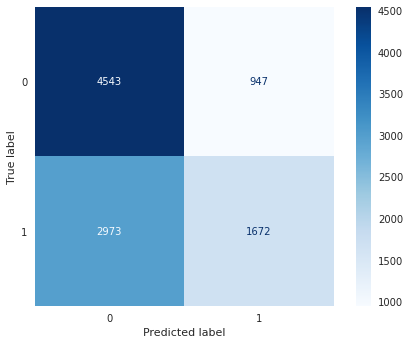

In [62]:
y_pred = rs.predict(X_test_scaled)
print(sklearn.metrics.classification_report(y_test, y_pred))
print(compute_scores(y_test, y_pred))
plot_confusion_matrix(rs.best_estimator_, X_test_scaled, y_test, cmap='Blues')
plt.grid(None)

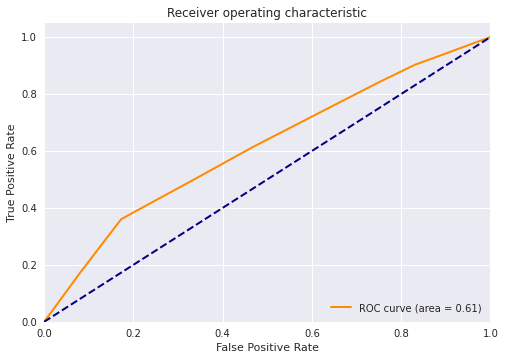

In [58]:
# Compute ROC curve and ROC area for each class
y_score = rs.best_estimator_.predict_proba(X_test_scaled)
fpr, tpr, _ = roc_curve(y_test, y_score.T[1])
roc_auc = auc(fpr, tpr)

plot_roc_curve(fpr, tpr, roc_auc)

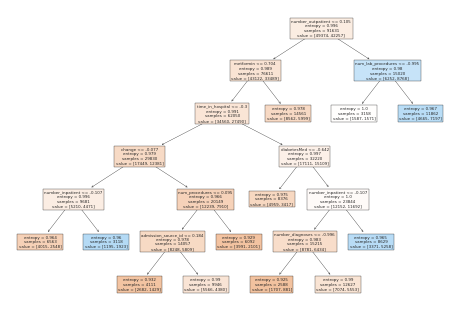

In [59]:
sklearn.tree.plot_tree(rs.best_estimator_,feature_names = X_train.columns, filled = True);

In [60]:
#RandomForestClassifier
rfbest=sklearn.model_selection.RandomizedSearchCV(
                   rf, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [10,20, 30, 40, 50, 60,
                                                      70, 80, 90, 100,110,
                                                      None],     
                                        'min_samples_leaf':[1,1.5,1.6,1.7,2],
                                        'max_features': ['auto', 'sqrt']},
                   random_state=42, verbose=1)

In [61]:
rfbest.fit(scaler.transform(X_train),y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


KeyboardInterrupt: 

In [41]:
print(rfbest.best_estimator_)
y_pred = rs.predict(X_test_scaled)
print(sklearn.metrics.classification_report(y_test, y_pred))
print(compute_scores(y_test, y_pred))
plot_confusion_matrix(rs.best_estimator_, X_test_scaled, y_test, cmap='Blues')

In [42]:
# Compute ROC curve and ROC area for each class
y_score = rfbest.best_estimator_.predict_proba(X_test_scaled)
fpr, tpr, _ = roc_curve(y_test, y_score.T[1])
roc_auc = auc(fpr, tpr)

plot_roc_curve(fpr, tpr, roc_auc)

In [43]:
#Top 10 importances feature
feat_importances = pd.Series(rfbest.best_estimator_.feature_importances_, index=X_train.columns)
plt.gcf().set_size_inches(16,10)
plt.title('Feature Importances')
plt.xlabel('Relative Importance')
feat_importances.nlargest(10).plot(kind='barh')
plt.savefig('feat_importances.png')
plt.show()